In [127]:
#Bidirectional LSTM
#DENSE OUTPUT LAYER

#Based on https://github.com/maetshju/gsoc2018/blob/master/speech-blstm/01-speech-blstm.jl
#and https://github.com/denizyuret/Knet.jl/blob/master/tutorial/60.rnn.ipynb

In [128]:
#Input Features = 13

#Emotions to train on
#01 (Neutral) and 03 (Happy)

##USING 23 NOW INSTEAD
#02 (Calm) and 03 (Happy)

In [240]:
using BSON


ENV["COLUMNS"] = 72
using Pkg; for p in ("Knet","IterTools","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Random: shuffle!
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Knet: Knet, AutoGrad, gpu, param, param0, mat, RNN, relu, Data, adam, sgd, progress, nll, zeroone

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.4/Pkg/src/Pkg.jl:531
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.4/Pkg/src/Pkg.jl:531
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.4/Pkg/src/Pkg.jl:531


In [130]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)


In [974]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; end
Dense(i::Int,o::Int,f=identity) = Dense(param(o,i), param0(o), f)
(d::Dense)(x) = d.f.(d.w * mat(x,dims=1) .+ d.b)

struct DenseRelu; w; b; f; end
DenseRelu(i::Int,o::Int,f=relu) = DenseRelu(param(o,i), param0(o), f)
(d::DenseRelu)(x) = d.f.(d.w * mat(x,dims=1) .+ d.b)

In [132]:
#Rule
include_1_3(x) = occursin(r"03-01-(?:01|03)-0[1-2]-0[1-2]-0[1-2]-[0-9][0-9].bson",x)

include_2_3(x) = occursin(r"03-01-(?:02|03)-0[1-2]-0[1-2]-0[1-2]-[0-9][0-9].bson",x)



include_2_3 (generic function with 1 method)

In [7]:
#Relabling rule
function encode_1_3(Y)

ARRAY = Array{Float32}
Ÿ = ARRAY(mat(Y))
    
m=ARRAY(zeros(2,length(y)));
    
    for i in 1:length(Ÿ)
        m[ (Ÿ[i]==1 ? 1 : 3) ,i]=1; 
    end
    
return m

end


#Relabling rule
function encode_2_3(Y)

ARRAY = Array{Float32}
Ÿ = ARRAY(mat(Y))
    
m=ARRAY(zeros(2,length(y)));
    
    for i in 1:length(Ÿ)
        m[ (Ÿ[i]==2 ? 1 : 3) ,i]=1; 
    end
    
return m

end



encode_1_3 (generic function with 1 method)

In [133]:
"""
    readData(dataDir)
Reads in the data contained in a specified directory
    
# Parameters
* **dataDir** String of the path to the directory containing the data
#LOAD BSON

# Return
* **Xs** Vector where each element is a vector of the frames for
one utterance
* **Ys** A vector where each element is a vector of the labels for
the frames for one utterance
"""

function readData(dataDir, rule)
    fnames = readdir(dataDir)

    Xs = Vector()
    Ys = Vector()
    
    for (i, fname) in enumerate(fnames)
        print(string(i) * "/" * string(length(fnames)) * "\r")
        #print(fname)
        if rule(fname) 
            BSON.@load joinpath(dataDir, fname) x y
            
            #println(summary(x));
            #x = [x[i,:] for i in 1:size(x,1)]
            #println(summary(x));
            #y = [y[i,:] for i in 1:size(y,1)]
            push!(Xs, x)
            #vcat(Xs, x)
            push!(Ys, y)
            #vcat(Ys, y)
            #println(y)
            #break
            #println(y)
            #return
        end
    end
    
    #EXPLICIT TYPING!!!
    return (Array{Float32,2}.(Xs), (Ys))
end


readData (generic function with 1 method)

In [134]:
#(Xs, Ys) =  readData("Datasets/ravdess-26-features", include_1_3);
(Xs, Ys) =  readData("Datasets/ravdess-26-features-2-3", include_2_3);

In [135]:
AllXs = (vcat(Xs...))
AllYs = (vcat(Ys...));

In [11]:
#MASH SAMPLES TOGETHER TO FORM A SUPERMASSIVE ARRAY!!!
#AllXs

#reshape(AllXs[1:100,:],13,20,5)


In [912]:
BATCHSIZE = 18
SEQLENGTH = 8;

#Since there is no embedding, you can just treat the features like the X dimension!

function seqbatch(x,y,F,B,T)
    
    #X IS ALREADY 2D DON'T DIVIDE BY LENGTH
    #N = length(x) ÷ B
    N = size(AllXs)[1] ÷ B
    println(N)
    println(B)
    println(T)
    
    x = (reshape(x[1:N*B,:],F,N,B))
    println(summary(x))
    
    y = (reshape(y[1:N*B,:],1,N,B))
    println(summary(y))
    
    d = []; for i in 0:T:N-T
        push!(d, (x[:,i+1:i+T,:], y[:,i+1:i+T,:]))
    end
    return d
end


function seqbatchTest(x,y,B,T)
    
    #X IS ALREADY 2D DON'T DIVIDE BY LENGTH
    #N = length(x) ÷ B
    println(size(AllXs)[1])
    N = size(AllXs)[1] ÷ B
    println(N)
    println(B)
    println(T)
    
    println(summary(y))
    y = (reshape(y[:,1:N*B,:],1,N,B))
    println(summary(y))
    
    #ONEHOT ENCODE
end




seqbatchTest (generic function with 1 method)

In [913]:
FEATURES = 26
HIDDENSIZE = 160
OUTPUTSIZE = 2;

In [914]:
d = seqbatch(AllXs, AllYs, FEATURES, BATCHSIZE, SEQLENGTH);
#d = seqbatchTest(AllXs, AllYs,  BATCHSIZE, SEQLENGTH);
#Target 2x64x32

7948
18
8
26×7948×18 Array{Float32,3}
1×7948×18 Array{UInt8,3}


In [915]:
#summary(d[1][2])


In [916]:
#display(permutedims(Xs))

In [917]:
#mat(Xs[1])

In [918]:
# shuffle and split minibatches into train and test portions
shuffle!(d)
dtst = d[1:10]
dtrn = d[11:end];

In [919]:
#size(dtrn[1],1)
length.((dtrn,dtst))

(983, 10)

In [920]:
function trainresults(file,maker,savemodel)
    if (print("Train from scratch? "); readline()[1]=='y')
        model = maker()
        results = ((nll(model,dtst), zeroone(model,dtst))
                   for x in takenth(progress(adam(model,ncycle(dtrn,5))),100))
        results = reshape(collect(Float32,flatten(results)),(2,:))
        Knet.save(file,"model",(savemodel ? model : nothing),"results",results)
        #serialize("EmRec160", model)
        Knet.gc() # To save gpu memory
    else
        println("¯\\_(ツ)_/¯")
    end
    println(minimum(results,dims=2))
    return model,results
end

trainresults (generic function with 1 method)

In [921]:
BIRNN(input,hidden,output)=  # biRNN 
Chain(RNN(input,hidden,rnnType=:relu,bidirectional=true,dataType=Float32),Dense(2hidden,output));

In [975]:
BIGRNN(input,hidden,hidden2,output)=  # biRNN 
Chain(RNN(input,hidden,rnnType=:relu,bidirectional=true,dataType=Float32),DenseRelu(2hidden,hidden2),Dense(hidden2,output));

In [993]:
BEEGRNN(input,hidden,hidden2,hidden3,output)=  # biRNN 
Chain(RNN(input,hidden,rnnType=:relu,bidirectional=true,dataType=Float32),DenseRelu(2hidden,hidden2),DenseRelu(hidden2,hidden3),Dense(hidden3,output));

In [1078]:
BEEGESTRNN(input,hidden,hidden2,hidden3,hidden4,output)=  # biRNN 
Chain(RNN(input,hidden,rnnType=:relu,bidirectional=true,dataType=Float32),DenseRelu(2hidden,hidden2),DenseRelu(hidden2,hidden3),DenseRelu(hidden3,hidden4),Dense(hidden4,output));

In [922]:
HIDDENSIZE = 190

EMREC() = BIRNN(FEATURES,HIDDENSIZE,OUTPUTSIZE)
(tEm,rEm) = trainresults("Emrec-2-3-190.jld2",EMREC,true);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 4915/4915, 02:37/02:37, 31.27i/s] 


Float32[0.48851445; 0.2326389]


In [1051]:
HIDDENSIZE1 = 128
HIDDENSIZE2 = 64

EMREC() = BIGRNN(FEATURES,HIDDENSIZE1,HIDDENSIZE2,OUTPUTSIZE)

(TEM,REM) = trainresults("BIGEMRECv2.jld2",EMREC,true);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 4915/4915, 01:43/01:43, 47.50i/s] 


Float32[0.48949966; 0.23125]


In [1059]:
HIDDENSIZE1 = 128
HIDDENSIZE2 = 64
HIDDENSIZE3 = 32

EMREC() = BEEGRNN(FEATURES,HIDDENSIZE1,HIDDENSIZE2,HIDDENSIZE3,OUTPUTSIZE)

(TEM,REM) = trainresults("BEEGEMREC.jld2",EMREC,true);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 4915/4915, 01:42/01:42, 48.34i/s] 


Float32[0.47396737; 0.21388888]


In [1088]:
HIDDENSIZE1 = 190
HIDDENSIZE2 = 90
HIDDENSIZE3 = 40
HIDDENSIZE4 = 20

EMREC() = BEEGESTRNN(FEATURES,HIDDENSIZE1,HIDDENSIZE2,HIDDENSIZE3,HIDDENSIZE4,OUTPUTSIZE)

(TEM,REM) = trainresults("BEEGESTEMRECv2.jld2",EMREC,true);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 4915/4915, 02:37/02:37, 31.22i/s] 


Float32[0.45473367; 0.19722222]


In [1111]:
MAGICRNN(input,hidden1,hidden2,output)=  # biRNN 
Chain(RNN(input,hidden1,rnnType=:relu,bidirectional=true,dataType=Float32),RNN(2hidden1,hidden2,rnnType=:relu,bidirectional=true,dataType=Float32),Dense(2hidden2,output));

In [1120]:
HIDDENSIZE1 = 128
HIDDENSIZE2 = 32

EMREC() = MAGICRNN(FEATURES,HIDDENSIZE1,HIDDENSIZE2,OUTPUTSIZE)
(TEM,REM) = trainresults("MagicEmRec.jld2",EMREC,true);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 4915/4915, 02:38/02:38, 31.15i/s] 


Float32[0.5181109; 0.2375]


In [1130]:
Knet.@load "BIGEMREC.jld2"
TEM,REM = model, results

(Chain((RNNRELU(input=26,hidden=80,bidirectional), DenseRelu(P(Array{Float32,2}(40,160)), P(Array{Float32,1}(40)), NNlib.relu), Dense(P(Array{Float32,2}(2,40)), P(Array{Float32,1}(2)), identity))), Float32[1.0988865 0.7251009 … 0.52871746 0.53654826; 0.49791667 0.47847223 … 0.25694445 0.24861111])

In [580]:
using Plots; default(fmt=:png,ls=:auto,ymirror=true)

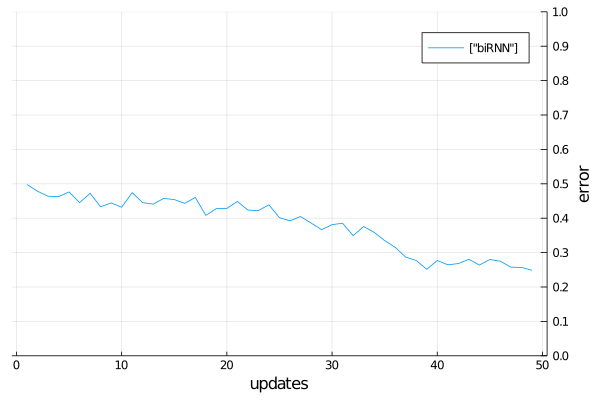

In [1129]:
plot([rEm[2,:]]; xlabel="updates", ylabel="error",
    ylim=(0,1), yticks=0:0.1:1, labels=["biRNN"])

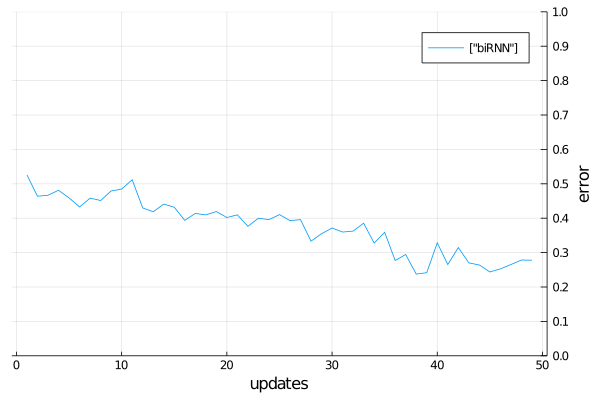

In [1122]:
plot([REM[2,:]]; xlabel="updates", ylabel="error",
    ylim=(0,1), yticks=0:0.1:1, labels=["biRNN"])

In [1123]:
#emotions = ["neutral","happy"]
#s=[1,2]
#emotions[s]
emotions = ["calm","happy"]

2-element Array{String,1}:
 "calm"
 "happy"

In [1124]:
function tag(tagger,k,L)
    #samples = s
    #println(samples)
    labels = emotions[(x->x[1]).(argmax(Array(tagger(reshape(Xs[k],26,1,L))),dims=1))]
    #vcat(samples,labels)
    labels
end

tag (generic function with 1 method)

In [1125]:
summary(Xs[12])

"368×26 Array{Float32,2}"

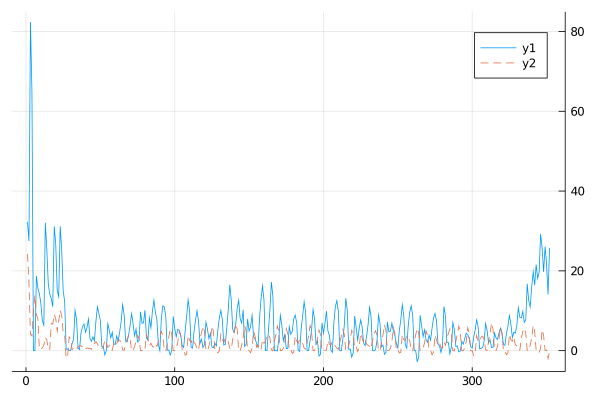

In [1126]:
#plot(reshape(tag(tEm,1,352),352))

plot(reshape(TEM(reshape(Xs[1],26,1,352)),352,2))
#plot(reshape(tEm(reshape(Xs[2],26,1,719)),719,2))

#plot(reshape(tEm(reshape(Xs[3],26,1,348)),348,2))
    
#plot(reshape(tag(tEm,1,352),352))

#plot(reshape(tEm(reshape(Xs[1],26,1,352)),352,2)[:,1]/10)
#plot(reshape(tEm(reshape(Xs[1],26,1,352)),352,2)[100:end,2])

#println(mean((tEm(reshape(Xs[1],26,1,352)))[1,:]))
#println(mean((tEm(reshape(Xs[1],26,1,352)))[2,:]))


#println(mean((tEm(reshape(Xs[2],26,1,719)))[1,:]))
#println(mean((tEm(reshape(Xs[2],26,1,719)))[2,:]))


#println(mean((tEm(reshape(Xs[3],26,1,348)))[1,:]))
#println(mean((tEm(reshape(Xs[3],26,1,348)))[2,:]))


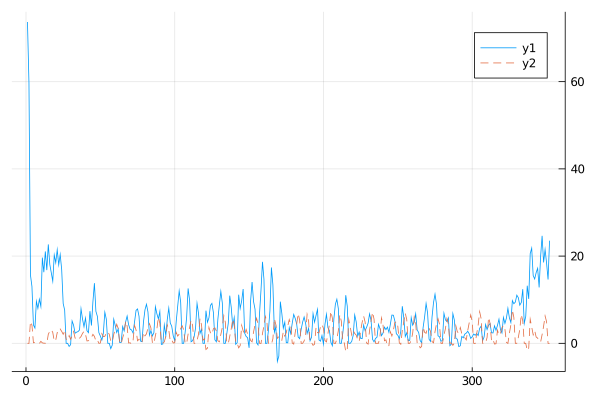

In [1127]:
using Statistics
#plot(reshape(tag(tEm,11,352),352))

plot(reshape(TEM(reshape(Xs[11],26,1,352)),352,2))
#plot(reshape(tEm(reshape(Xs[12],26,1,368)),368,2))

#plot(reshape(tEm(reshape(Xs[11],26,1,352)),352,2)[:,2])

# mean(reshape(tEm(reshape(Xs[11],26,1,352)),352,2)[1])

# println(mean((tEm(reshape(Xs[11],26,1,352)))[1,:]))
# println(mean((tEm(reshape(Xs[11],26,1,352)))[2,:]))

# println(mean((tEm(reshape(Xs[12],26,1,368)))[1,:]))
# println(mean((tEm(reshape(Xs[12],26,1,368)))[2,:]))

In [1128]:
println(count(i->(i=="happy"),tag(TEM,1,352))/352 )
#println(count(i->(i=="happy"),tag(TEM,2,332))/332 )
println(count(i->(i=="happy"),tag(TEM,11,352))/352 )
println(count(i->(i=="happy"),tag(TEM,12,368))/368 )



0.4715909090909091
0.4715909090909091
0.47282608695652173


In [1028]:
println(summary(reshape(Xs[1],26,1,328)))
tEm( reshape(Xs[1],26,1,328) ) 



DimensionMismatch: DimensionMismatch("new dimensions (26, 1, 328) must be consistent with array size 9152")

In [33]:
reshape(Xs[1],26,1,328)

26×1×328 Array{Float32,3}:
[:, :, 1] =
 -158.44759
 -504.6143
 -167.6936
 -136.85472
 -145.15147
 -125.939644
 -144.97498
 -128.19456
 -123.62134
 -128.04933
 -121.64569
 -131.79652
 -144.95607
 -132.5605
 -131.79839
 -120.24388
 -114.45146
 -132.20493
 -146.28842
 -133.9444
 -121.4317
 -122.54968
 -135.39066
 -120.81583
 -125.24479
 -148.99736

[:, :, 2] =
 -152.01717
 -129.17183
 -128.77753
 -123.08497
 -118.05649
 -129.42528
 -144.80547
 -158.45955
 -133.35197
 -138.40515
 -127.94004
 -129.50296
 -163.9895
 -133.83154
 -147.7202
 -155.95316
 -131.39186
 -139.14969
 -504.6143
 -136.34299
 -141.58849
 -134.33522
 -150.74562
 -504.6143
 -144.35312
 -137.95537

[:, :, 3] =
 -135.96745
 -135.85068
 -134.13023
 -138.34065
 -141.93942
 -122.505226
 -124.69218
 -135.82951
 -138.99739
 -504.6143
 -140.20514
 -132.4192
 -138.37752
 -136.61874
 -167.43106
 -126.84669
 -114.310646
 -131.92824
 -129.47511
 -128.79141
 -123.33966
 -109.99274
 -109.62951
 -107.56798
 -105.977325
 -112.71718

...



In [1022]:
FRAME_LENGTH = 0.025 # ms
FRAME_INTERVAL = 0.010 # ms

export detect


function preprocess(wavFile)
    samps, sr = load(wavFile)
    samps = vec(samps)
    
    #.+ eps to avoid Inf's and NaN's
    samps.+=eps()

    #26 FEATURES
    #Kind of handles resampling! Consider lowering quality of training data if accuracy is too off
    mfccs, _, _ = mfcc(samps, sr, :rasta; wintime=FRAME_LENGTH, steptime=FRAME_INTERVAL)
    mfccDeltas = deltas(mfccs, 2)
    features = hcat(mfccs, mfccDeltas)
    
    toReturn = Float32.(features)
    return toReturn
end


function tag(M,features,S)
	emotions = ["neutral","happy"]
    #labels = emotions[(x->x[1]).(argmax(Array(model(reshape(SAMPLES,features,1,L))),dims=1))]
    labels = emotions[(x->x[1]).(argmax(Array(M(S)),dims=1))]
    return labels
end

function detect(fileLoc)

	SAMPLES = (preprocess(fileLoc))
	#LOAD MODEL
	#model = Knet.load("EmRec256.jld2","model")
	#println(size(SAMPLES))
    L = size(SAMPLES)[1]

	#KNET LOAD BROKEN REPORT THIS!
	#Knet.@load "EmRec256.jld2"
	println(model)

	#model = deserialize("EmRec160")

    #println(summary(reshape(SAMPLES,26,1,598)))

    #(model(reshape(SAMPLES,26,1,598)))
	#reshape(Xs[1],26,1,328)

	#TAG
    return(reshape(TEM(reshape(SAMPLES,26,1,L)),L,2))
	#tag(model, 26, reshape(SAMPLES,26,1,L))
	#COUNT TAG
end


function test(fileLoc)
	return(detect(fileLoc))
end

test (generic function with 1 method)

In [1023]:
using FileIO: load, save, loadstreaming, savestreaming
using MFCC

In [1103]:
k=(test("etsworking.wav"))

Chain((RNNRELU(input=26,hidden=80,bidirectional), DenseRelu(P(Array{Float32,2}(40,160)), P(Array{Float32,1}(40)), NNlib.relu), Dense(P(Array{Float32,2}(2,40)), P(Array{Float32,1}(2)), identity)))


598×2 Array{Float32,2}:
 -4.79707     1.51966
 -8.54747     1.1753
 -3.25727     0.88721
 -4.01658     0.685984
 -4.53125     0.791283
 -2.98426     0.953729
  1.88468     0.165912
  1.44419     0.220885
  5.76785     0.92611
  4.00337     1.03329
 10.8102      0.407864
 13.385       0.491978
 17.6819      1.9528
  ⋮          
 -2.67823    -1.44216
 -2.4606     -2.76951
 -1.14645     0.00574248
 -1.39487    -0.00574259
 -0.314611    5.72257
  0.0745016   8.15088
 -0.348456   -1.52283
 -0.238272   -2.92349
 -0.353659   -0.439765
 -0.440413   -0.538032
  0.446442    6.41985
  0.641658    8.78757

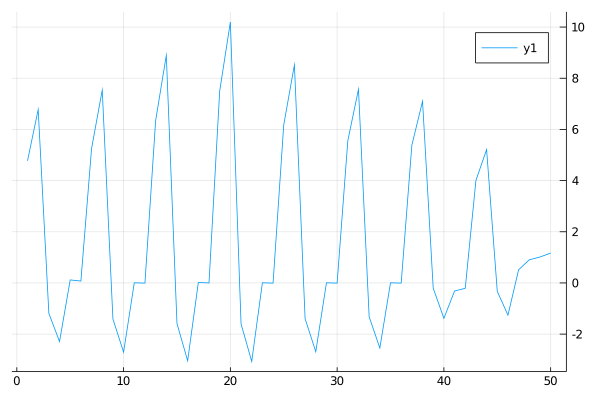

In [1110]:
plot(k[151:200,2])

In [ ]:
#Key to happiness
#Take a frame of size 